## SER-SAG Periodicity Pipeline (LSST in-kind contribution project)

<i> <b> Abstract </i> </b>: Our periodicity-search pipeline includes nonparametric and parametric light curve modelling, based on   different time-domain period-detection algorithms, and a set of techniques for determining the significance level of potential periods. The proposed pipeline combines different time-domain algorithms, including machine learning of light curves, to exploits the information. The pipeline outputs are the extracted light curve periodic features (periodicities, uncertainties, periods probability) which will serve especially the TVS and AGN science collaborations, as well as any other interestred group, for further variability investigations.

<p> 
The software is currently under development, and it will be developed as a  python package available to download and distribute using the PyPi repository. We have made this choice in order to distribute, maintain, and develop software and its versions more easily. Also, the package can be easily installed and executed on the RSP platform.
</p>

<p>
    The package will be separated into a few different modules: </p>
    <ol>
        <li> read module. Read module is primarily used for data acquisition and pre-processing. It will fetch data (either from RSP or user data), and it will check if all necessary pieces of information are given, normalize it and create input objects that will be used as input in our pipeline. For the pipeline to function correctly, initial data must have Object ID, time, flux, flux uncertainty, multi-band LSST Lomb-Scargle periodicity, and it must be supplied by the user (or the connecting system, such as RSP). Read module will have three sub-modules. The first one, named lsst, will be intended for reading and obtaining data from lsst RSP. It will have different functions that will be able to reach lsst data remotely (using API or tas protocol) or directly in RSP. The second one, named user, will have similar functions but for the data supplied by the user. The third one is used for data normalization and basic pre-processing.  </li>
 
<li> Utils module. The purpose of this module is to store any functions that can be used as utilities, e.g., functions to simulate artificial light curves or any other calculation-based functions such as autocorrelation functions, etc. </li>

<li> Plots module. This module's primary purpose is for the graphical representation of data. It has functions to visualize input data, as well as output data. </li>

<li> Output module. This module's purpose is to obtain output data as Python objects. It will have functions that implement our pipeline to obtain periodic features of the LC. Also, it will have the ability to simultaneously execute a vast number of different LC to obtain catalogs with periodicities. To logically organize the module, it will have two sub-modules, one for obtaining periodicity features for a single LC and the other with functions for multiple light curves. </li>
        </ol>





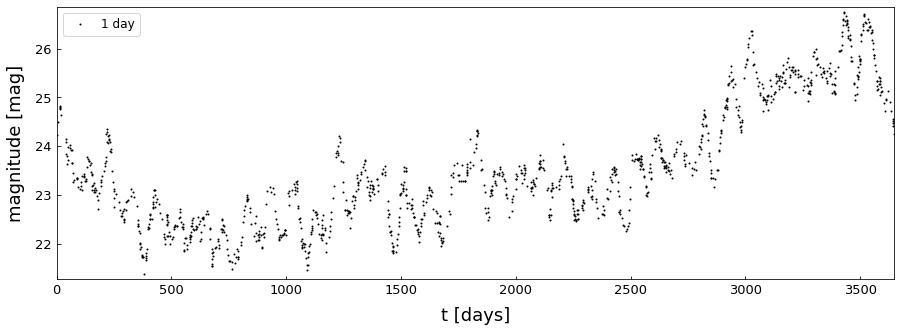

In [13]:
import sys
sys.path.insert(0, '/home/viktor/Documents/LSST/MAF/inkind/baseperiodicity')
from periodicity import *

# Creating of a mock signal LC with frequency of 20 days
period = 100  #days
amplitude = 0.4

# def simple_mock_lc( time_interval, num_points, frequency, amplitude, percent, magnitude = 20, time_unit = 'year'):
tt, yy = simple_mock_lc(time_interval = 10, num_points = 2048, 
                                    frequency = period, amplitude = amplitude, percent = 0.4, magnitude = 22)
fig_plot(tt, yy)

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.492
largest tau window is  46.152
67.91 seconds has passed to complete Weighted Wavelet Z-transform 

--- 67.96300005912781 seconds ---
98.96091044037611


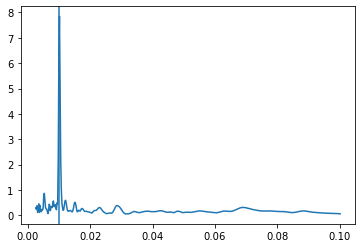

In [14]:
#Parameters for WWZ
fmax = 1/ 10 
fmin = 1/ 400
df = (fmax - fmin) / 500
time_division = 80
params = [fmin, fmax, df, True] 


import time
start_time = time.time()


wwt_result, params = wwt(tt, yy, time_division, params)
peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

print("--- %s seconds ---" % (time.time() - start_time))
print(result)

Text(0, 0.5, 'Period in $d^{-1}$')

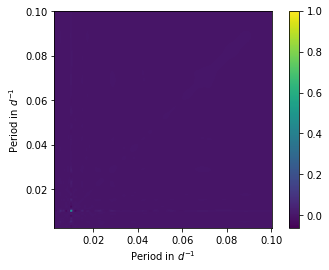

In [15]:
corr1=correlation_nd(np.rot90(wwt_result[2]),np.rot90(wwt_result[2]))
extentmin=np.min(wwt_result[1])
extentmax=np.max(wwt_result[1])
extent=[extentmin,extentmax,extentmin,extentmax]
plt.imshow(np.rot90(corr1).T/corr1.max(),extent=extent),plt.colorbar()
plt.xlabel('Period in $d^{-1}$')
plt.ylabel('Period in $d^{-1}$')
# plt.axvline(1/(100.),ymin=0,ymax=1)
# plt.axhline(1/(100.))

In [24]:
#import maf
from rubin_sim.maf import *
import numpy as np
import pandas as pd

opsim_name = 'multi_short_v2.0_10yrs'
opsim_db = OpsimDatabase('/home/viktor/Desktop/LSST/MAF/data/' + opsim_name + '.db')

In [25]:
opsim_data = maf_cadence(opsim_db, opsim_name , 9.45,-44.0)

Querying database observations with constraint filter = 'r' for columns ['filter', 'rotSkyPos', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 771557 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


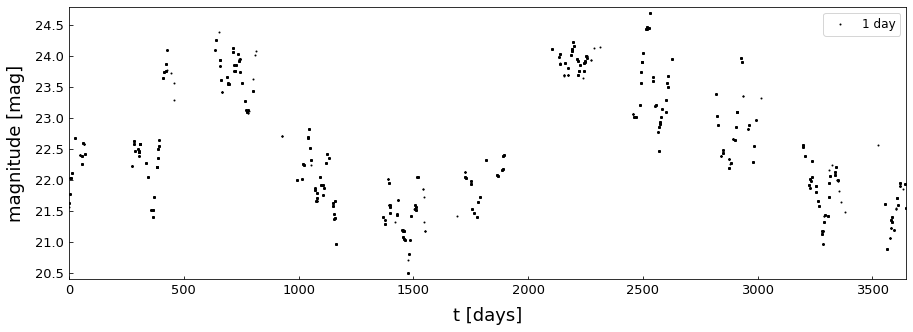

In [29]:
tt, yy = simple_mock_lc(time_interval = 10, num_points = 2048, 
                                    frequency = period, amplitude = amplitude, percent = 0, magnitude = 22)
ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
fig_plot(ttt, yyy)

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.164
506.47 seconds has passed to complete Weighted Wavelet Z-transform 

--- 506.5024094581604 seconds ---
96.77419354838526


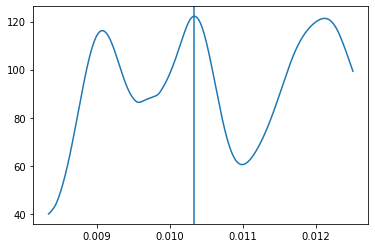

In [31]:
#Parameters for WWZ
fmax = 1/ 80
fmin = 1/ 120
df = (fmax - fmin) / 500
time_division = 80
params = [fmin, fmax, df, True] 


import time
start_time = time.time()


wwt_result, params = wwt(ttt, yyy, time_division, params)
peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

print("--- %s seconds ---" % (time.time() - start_time))
print(result)

In [23]:
def maf_cadence(opsim, name, ra = 0, dec = 0, fil = 'r'):
    colmn = 'observationStartMJD';
    outDir = 'TmpDir'
    resultsDb = ResultsDb(outDir=outDir)
    metric=PassMetric(cols=[colmn, 'filter'])
    slicer = UserPointsSlicer(ra=ra,dec=dec)
    sqlconstraint = 'filter = \'' + fil + '\''
   
    
    # Run simulation
    bundle = MetricBundle(
        metric, slicer, sqlconstraint, runName=name)
    bgroup = MetricBundleGroup(
        {0: bundle}, opsim, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll();
    filters = np.unique(bundle.metricValues[0]['filter'])
    mv = bundle.metricValues[0]
    
    
    # Get dates
    mjd  = (mv[colmn])
    return np.sort(mjd)